## This notebook serves as a introduction to ViT's

My notes are based on the following resources:
- [Image Classification with Vision Transformer](https://towardsdatascience.com/image-classification-with-vision-transformer-8bfde8e541d4)

**Dataset Used**
- "Snacks" dataset from 🤗 `datasets` library


### How ViT Works

- Transformers rely on *self-attention*
  - Allows transformerts to differentiate between semantic meanings of words in
    different contexts
- *self-attention* is Computationally expensive, so can't run on every pixel 
  in an image
- Instead, for ViT, the images are split into *patches* and each patch is 
  treated as a token
- There are two options for how ViT splits an image into patches:
  - Reshape oritinal image (H, W, C) into a sequence of flattened 2D images
    (P, patch_size^2 * C); then project flattened patches to a linear layer
    for *embeddings*
  - Project image into a convolutional layer with `kernel_size = stride = patch_size`
    and then flatten the output.
- This process is summarized below:

![ViT](https://miro.medium.com/v2/resize:fit:720/format:webp/1*H-1NL4T93uN1dl54u2R3Ig.png)

In [1]:
import torch
import torch.nn as nn

In [2]:
# Create toy image with dim (batch x channel x width x height)
image = torch.rand(1, 3, 48, 48)

# Define params for conv layer
num_channels = 3
hidden_size = 768  # embedding dim
patch_size = 16

# Define conv layer
projection = nn.Conv2d(
    in_channels=num_channels,
    out_channels=hidden_size,
    kernel_size=patch_size,
    stride=patch_size,
)

# Forward pass
logits = projection(image)

print(f"Original image shape: {image.shape}")
print(f"Projected image shape: {logits.shape}")

Original image shape: torch.Size([1, 3, 48, 48])
Projected image shape: torch.Size([1, 768, 3, 3])


The final embedding of the image is composed of embeddings for each of the patches in the projected image. The embedding for each patch is a vector of length `hidden_size`.

In [3]:
# Flatten output from projection -> embedding
patch_embeddings = logits.flatten(2).transpose(1, 2)

# (batch_size, num_patches, embedding_dim)
print(f"Embedding shape: {patch_embeddings.shape}")

Embedding shape: torch.Size([1, 9, 768])


This process is similar for Transformer-based language models.

Next, we will add a special vector embeddingfor the `[CLS]` token to the first position of the patches sequence.
- The `[CLS]` (classification) token is used to classify the entire 
  sequence (attend to all patches)
- The `[CLS]` token is a trainable parameter, so it can be used to 
  learn representations of the entire image

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Pm7Om8Td2n61ePvmDML7Eg.png)

In [4]:
# Define [CLS] token
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_token = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token to embeddings
patch_embeddings = torch.cat((cls_token, patch_embeddings), dim=1)
print(f"Embedding shape: {patch_embeddings.shape}")

Embedding shape: torch.Size([1, 10, 768])


Finally, we will add the positional embedding to the sequence of patch embeddings. The positional embedding is a trainable parameter, so it can be used to learn the relative position of patches in the image.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*C2q2-MqK0hTSnp8RfPTZ8A.png)

In [5]:
# Define position embeddings
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embeddings to embeddings
embeddings = patch_embeddings + position_embeddings
print(f"Embedding shape: {embeddings.shape}")

Embedding shape: torch.Size([1, 10, 768])


Thus, the position embeddings + patch embeddings will be the input
to a stack of Transformer encoders. 

#### Types of ViT

- **ViT-base** - 12 Transformer encoder layers, 12 attention heads, 768 hidden size, 86M parameters
- **ViT-large** - 24 Transformer encoder layers, 16 attention heads, 1024 hidden size, 307M parameters
- **ViT-huge** - 32 Transformer encoder layers, 32 attention heads, 1280 hidden size, 632M parameters

Here, we will implement a *ViT-b* model.

In [6]:
# Define parameters
num_heads = 12
num_layers = 12

# Define Transformer Encoders' stack
encoder_layer = nn.TransformerEncoderLayer(
    d_model=hidden_size,
    nhead=num_heads,
    dim_feedforward=int(hidden_size * 4),
    dropout=0.1
)
encoder = nn.TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=num_layers
)

# Forward pass
output = encoder(embeddings)
print(f"Transformer output shape: {output.shape}")

Transformer output shape: torch.Size([1, 10, 768])


Finally, the stack of Transformer encoders will output the final vector representation of each image patch. The dimensionality of the final vector corresponds to the hidden size of the ViT model that we use.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*rNtzVg0sIU7kxG1hTzaV4w.png)

### Pre-Trained ViTs

- Like other Transformer-based models, ViT requires training on large datasets for them to generalize well on new data
- We can use the `ViTModel()` class from the `transformers` library to load a pre-trained ViT model

In [7]:
from transformers import ViTModel

# Load pretrained ViT model
model_checkpoint = "google/vit-base-patch16-224-in21k"
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
image = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass
output = model(image)
print(f"Transformer output shape: {output.last_hidden_state.shape}")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformer output shape: torch.Size([1, 197, 768])


The output of the complete ViT model is a vector embedding representing each image patch plus the [CLS] token. It has the dimension of [batch_size, image_patches+1, hidden_size].

#### Classification

- To perform classification, we use the same approach as BERT
- We add a linear layer on top of the final vector embedding of the [CLS] token
- The linear layer will output a vector of length `num_classes` (the number of classes in the dataset)

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Ki2FDUm2UW-TVdMyj5ZZEw.png)

In [8]:
num_classes = 20

# Define linear classifier
classifier = nn.Linear(hidden_size, num_classes)

# Forward pass on ouput embedding of [CLS] token
output = classifier(output.last_hidden_state[:, 0, :])

print(f"Classifier output shape: {output.shape}")

Classifier output shape: torch.Size([1, 20])


### Fine-Tuning

- Here, we will fine tune a ViT-base model that was pretrained on ImageNet-21K
  (~14M images, 21843 classes)
- ImageNet-21K
  - Each image is 224x224 pixels
  - Normalized to mean = 0.5, std = 0.5

In [9]:
# Load necessary libraries
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from datasets import load_dataset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import cv2
import os

# Define a checkpoint path
checkpoint = "google/vit-base-patch16-224-in21k"

# Define custom dataset
class ImageDataset(Dataset):
    """Custom dataset for loading images"""

    def __init__(self, input_data):
        self.input_data = input_data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            )
        ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        images = self.get_images(idx)
        labels = self.get_labels(idx)
        return images, labels

    def get_images(self, idx):
        return self.transform(self.input_data[idx]['image'])

    def get_labels(self, idx):
        return self.input_data[idx]['label']

In [10]:
# Load dataset
dataset = load_dataset("Matthijs/snacks")
print(dataset)

# Print labels
print(dataset["train"].features['label'].names)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})
['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


In [11]:
# Mapping from label to index and vice versa
labels = dataset["train"].features['label'].names
num_labels = len(labels)
label2idx, idx2label = {}, {}
for i, label in enumerate(labels):
    label2idx[label] = i
    idx2label[i] = label

print(label2idx)
print(idx2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


- To construct the model, we will use `ViTModel.from_pretrained()` to load
  the weights. We will also add a linear layer at the end for classification

In [12]:
class ViT(nn.Module):
    """ViT Model"""

    def __init__(
        self,
        config=ViTConfig(),
        num_labels=20,
        checkpoint="google/vit-base-patch16-224-in21k"
    ):
        super(ViT, self).__init__()

        self.ViT = ViTModel.from_pretrained(checkpoint, add_pooling_layer=False)
        self.clf = nn.Linear(config.hidden_size, num_labels)

    def forward(self, x):
        x = self.ViT(x)
        x = x.last_hidden_state[:, 0, :]
        output = self.clf(x)

        return output

- Next, we can define a training loop

In [13]:
def model_train(dataset, epochs, learning_rate, batch_size):

    # Pick a device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load model, loss function and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=1
    )

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0.0
        total_loss_train = 0.0

        for images, labels in tqdm(train_loader):
            # move to device
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate accuracy
            corrects = (outputs.argmax(dim=1) == labels).sum().item()
            total_acc_train += corrects
            total_loss_train += loss.item()

        print(f'Epoch {i+1}/{epochs} | Loss: {total_loss_train/len(train_dataset):.4f} | Accuracy: {total_acc_train/len(train_dataset):.4f}')

    return model


In [14]:
# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

# Train model
model = model_train(dataset['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 76/76 [02:34<00:00,  2.03s/it]


Epoch 1/10 | Loss: 0.0286 | Accuracy: 0.7945


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 2/10 | Loss: 0.0079 | Accuracy: 0.9653


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 3/10 | Loss: 0.0032 | Accuracy: 0.9915


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 4/10 | Loss: 0.0016 | Accuracy: 0.9969


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 5/10 | Loss: 0.0011 | Accuracy: 0.9992


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 6/10 | Loss: 0.0007 | Accuracy: 0.9998


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 7/10 | Loss: 0.0005 | Accuracy: 1.0000


100%|██████████| 76/76 [02:34<00:00,  2.03s/it]


Epoch 8/10 | Loss: 0.0004 | Accuracy: 1.0000


100%|██████████| 76/76 [02:33<00:00,  2.02s/it]


Epoch 9/10 | Loss: 0.0003 | Accuracy: 1.0000


100%|██████████| 76/76 [02:34<00:00,  2.03s/it]

Epoch 10/10 | Loss: 0.0003 | Accuracy: 1.0000


- Now that we have a fine-tuned model, we can use it to make predictions on
  new images

In [15]:
def predict(image):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])

    image = transform(image)
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1).item()

    return idx2label[pred]

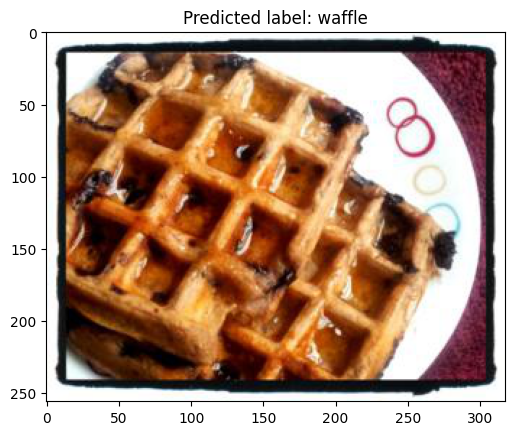

In [18]:
image = dataset['test'][900]['image']
pred = predict(image)

plt.imshow(image)
plt.title(f"Predicted label: {pred}");

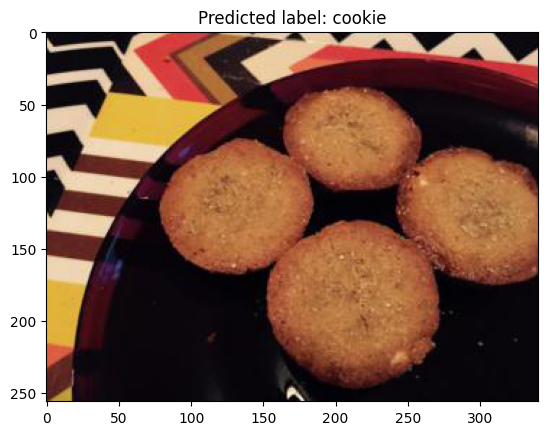

In [17]:
image = dataset['test'][250]['image']
pred = predict(image)

plt.imshow(image)
plt.title(f"Predicted label: {pred}");